In [1]:
#!pip uninstall numpy
!pip install karateclub
from karateclub.utils.walker import RandomWalker, BiasedRandomWalker
from karateclub import DeepWalk, Node2Vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter

#Handling bipartite graphs
import networkx as nx
from networkx.algorithms import bipartite

#Visualization
import scipy.sparse as sparse
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
from google.colab import files
uploaded = files.upload()

Saving fgraph_C.txt to fgraph_C.txt


In [4]:
fgraph_C = pd.read_csv('fgraph_C.txt', sep=" ", header=None)
fgraph_C = fgraph_C.drop_duplicates()
display(fgraph_C)

,0,1
0,a20.c,compiler_types.h
1,a20.c,linkage.h
2,a20.c,export.h
3,a20.c,compiler.h
4,a20.c,types.h
...,...,...
2743601,irqbypass.mod.c,error-injection.h
2743606,irqbypass.mod.c,utsrelease.h
2743607,irqbypass.mod.c,build-salt.h
2743608,irqbypass.mod.c,elfnote.h


In [5]:
hh_index = fgraph_C[fgraph_C[0].str.contains("\.h") & fgraph_C[1].str.contains("\.h")].index
cc_index = fgraph_C[fgraph_C[0].str.contains("\.c") & fgraph_C[1].str.contains("\.c")].index
fgraph_C = fgraph_C.drop(hh_index)
fgraph_C = fgraph_C.drop(cc_index)
print("The number of relationships of type .c->.h is ",Counter(fgraph_C[0].str.contains("\.c") & fgraph_C[1].str.contains("\.h"))[True])
print("The number of relationships of type .h->.h is ",Counter(fgraph_C[0].str.contains("\.h") & fgraph_C[1].str.contains("\.h"))[True])
print("The number of relationships of type .c->.c is ",Counter(fgraph_C[0].str.contains("\.c") & fgraph_C[1].str.contains("\.c"))[True])
print("The number of relationships of type .h->.c is ",Counter(fgraph_C[0].str.contains("\.h") & fgraph_C[1].str.contains("\.c"))[True])

The number of relationships of type .c->.h is  1884257
The number of relationships of type .h->.h is  0
The number of relationships of type .c->.c is  0
The number of relationships of type .h->.c is  0


In [6]:
compile_graph = nx.Graph() 
# Add nodes with the node attribute "bipartite" (This is a convention when using bipartite graphs in networkx)
compile_graph.add_nodes_from(list(set(fgraph_C[0])), bipartite=0)
compile_graph.add_nodes_from(list(set(fgraph_C[1])), bipartite=1)
# Add edges only between nodes of opposite node sets
compile_graph.add_edges_from(list(fgraph_C.itertuples(index=False, name=None)))
top_nodes = {n for n, d in compile_graph.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(compile_graph) - top_nodes
h_graph = bipartite.projected_graph(compile_graph, bottom_nodes)

# Node Embeddings generation, visualization and interpretation

Libraries



> - Karate Club is an unsupervised machine learning extension library for NetworkX. It builds on other open source linear algebra, machine learning, and graph signal processing libraries such as Numpy, Scipy, Gensim, PyGSP, and Scikit-Learn. Karate Club consists of state-of-the-art methods to do unsupervised learning on graph structured data.
https://karateclub.readthedocs.io/en/latest/
- UMAP is a general purpose manifold learning and dimension reduction algorithm.
https://umap-learn.readthedocs.io/en/latest/

We experimented with DeepWalk algorithm from karateclub library.

In [7]:
!pip install umap
!pip install umap-learn
import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
mpl.rcParams['figure.figsize'] = 20, 12
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=3a6045260224c029e0b8054bf3c99acd586555a907c53c41ae4a54c060d5e4eb
  Stored in directory: /root/.cache/pip/wheels/d4/13/91/2e752dc8dab5df027854bd33d2b65e1dc5cdc107fd1133990f
Successfully built umap
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=a24425b4968ce624e97ce6cf63feb6e80b47b3bd4b6d45365eb0167416d70306
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a2

In [8]:
# Relabelling is necessary for DeepWalk to work with integer indexing of nodes
relabelling_dict = {}
for index, node in enumerate(h_graph.nodes()):
  relabelling_dict[node] = index
h_graph_index = nx.relabel_nodes(h_graph, relabelling_dict)

# DeepWalk

## Computation

In [22]:
model = DeepWalk(dimensions=128, walk_number = 20, walk_length = 40)
model.fit(h_graph_index) 
h_graph_embeddings = model.get_embedding()
print('Number of projected hgraph nodes:', len(h_graph.nodes))
print('Embedding array shape:', h_graph_embeddings.shape)

Number of projected hgraph nodes: 3396
Embedding array shape: (3396, 128)


In [73]:
# save the vectors
with open("vectors.txt", "w") as f:
    f.write(str(h_graph_embeddings))

## The silhouette score
Silhouette refers to a method of interpretation and validation of consistency within clusters of data taking into account both intra-cluster and inter-cluster distances.

Based on this score both 5,6 clusters are the solution with positive an highest silhouette score. 2 in not taken into consideration as it would not be really infromative for a follow-up interpretation of the results.

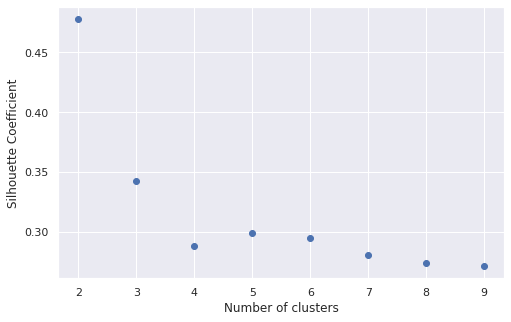

In [105]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
mpl.rcParams['figure.figsize'] = 8, 5

silhouette_coeffs = []
for i in range(2,10):
  kmeans_labels = KMeans(n_clusters=i, random_state=0).fit_predict(h_graph_embeddings)

  # Calculate silhouette coefficient
  silhouette_coeff = silhouette_score(h_graph_embeddings, kmeans_labels)
  silhouette_coeffs.append(silhouette_coeff)

# Scatterplot
plt.scatter(range(2,10), silhouette_coeffs)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

## Visualization

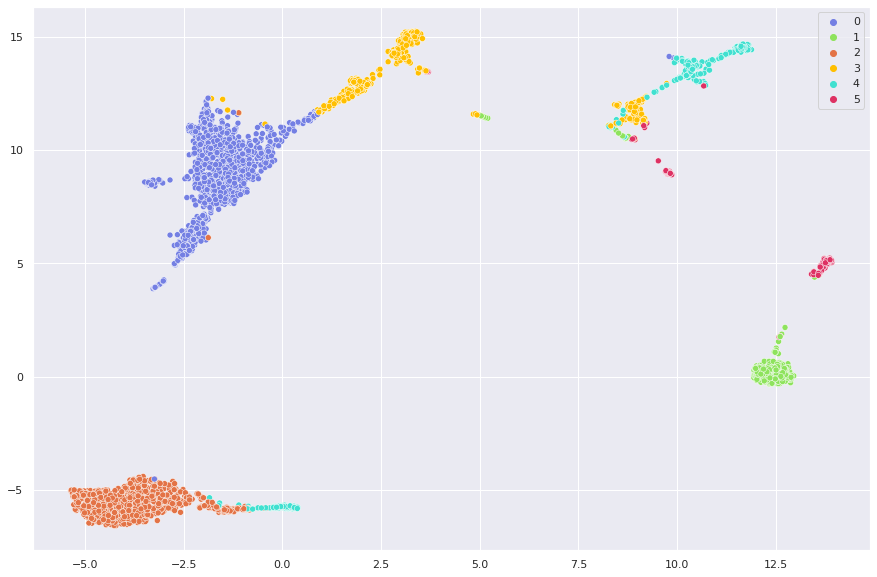

In [23]:
mpl.rcParams['figure.figsize'] = 15, 10

kmeans = KMeans(n_clusters= 6)
u = umap.UMAP(random_state=42)
dw_umap_embs = u.fit_transform(h_graph_embeddings)
label = kmeans.fit_predict(h_graph_embeddings)
sns.set()
colors = ['#747FE3', '#8EE35D', '#E37346','#FFBF00','#40E0D0','#DE3163']

ax = sns.scatterplot(x = dw_umap_embs[:, 0], y = dw_umap_embs[:, 1], hue = label,palette=colors)

## Interpretation


The different clusters seem to show the presence of distinct communities of files visually depicted in Figure 6:
- Cluster 0 shows that, as for the modularity clustering, also in this case the files connected to the bnx2x driver are clustered together. They are, together with other files, hinting for a cluster of driver communication files.
- Cluster 1 gathers the aforementioned most important .h files. Their node embeddings result in being similar between them, therefore files in this cluster could be seen as a building block for the main functionalities of the linux kernel.
- Cluster 2 highlights the presence of files that connect Audio and Video functionalities.
- Clusters 3 and 5 gather together the building block of the Linux kernel networking architecture.
- Cluster 4 is of much harder interpretation.However some of the files suggest to deal with basic cpu properties and usage.

Text(-5.013039340972901, -5.843166160583496, 'usbtv.h')

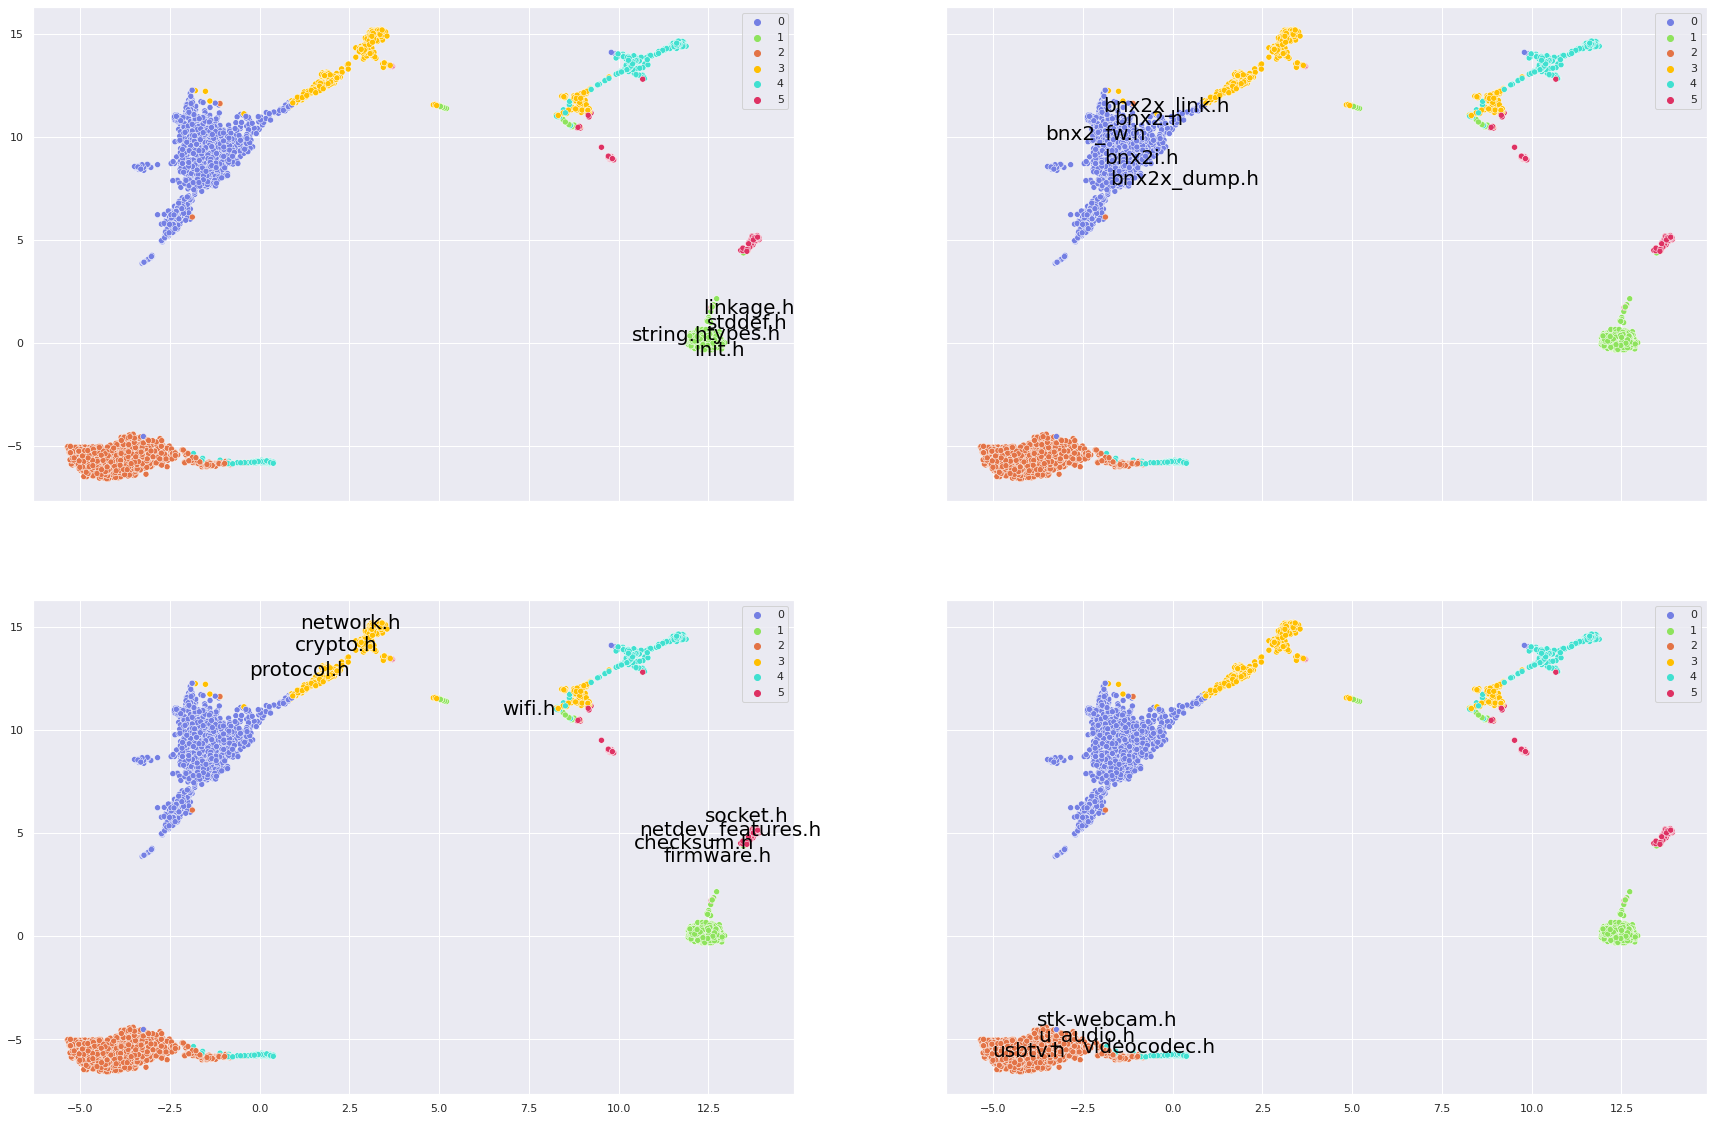

In [103]:
fig, ax = plt.subplots(2,2,sharex= True,sharey=True)
mpl.rcParams['figure.figsize'] = 35, 20

ax[0,0] = sns.scatterplot(x = dw_umap_embs[:, 0], y = dw_umap_embs[:, 1], hue = label,palette=colors,ax=ax[0,0])
ax[0,0].text(dw_umap_embs[relabelling_dict['linkage.h']][0]+0.01, dw_umap_embs[relabelling_dict['linkage.h']][1]+1.60,
        np.array(h_graph.nodes)[relabelling_dict['linkage.h']], horizontalalignment='left', fontsize=20, color='black')
ax[0,0].text(dw_umap_embs[relabelling_dict['types.h']][0]+0.01, dw_umap_embs[relabelling_dict['types.h']][1]+0.10,np.array(h_graph.nodes)[relabelling_dict['types.h']], horizontalalignment='left', fontsize=20, color='black')
ax[0,0].text(dw_umap_embs[relabelling_dict['stddef.h']][0]+ 0.01, dw_umap_embs[relabelling_dict['stddef.h']][1]+0.70,np.array(h_graph.nodes)[relabelling_dict['stddef.h']], horizontalalignment='left', fontsize=20, color='black')
ax[0,0].text(dw_umap_embs[relabelling_dict['init.h']][0]+ 0.01, dw_umap_embs[relabelling_dict['init.h']][1]-1.00,np.array(h_graph.nodes)[relabelling_dict['init.h']], horizontalalignment='left', fontsize=20, color='black')
ax[0,0].text(dw_umap_embs[relabelling_dict['string.h']][0]-1.80, dw_umap_embs[relabelling_dict['string.h']][1]+0.10,np.array(h_graph.nodes)[relabelling_dict['string.h']], horizontalalignment='left', fontsize=20, color='black')

ax[0,1] = sns.scatterplot(x = dw_umap_embs[:, 0], y = dw_umap_embs[:, 1], hue = label,palette=colors,ax=ax[0,1])
ax[0,1].text(dw_umap_embs[relabelling_dict['bnx2i.h']][0]+0.01, dw_umap_embs[relabelling_dict['bnx2i.h']][1]+0.60,np.array(h_graph.nodes)[relabelling_dict['bnx2i.h']], horizontalalignment='left', fontsize=20, color='black')
ax[0,1].text(dw_umap_embs[relabelling_dict['bnx2.h']][0]+0.01, dw_umap_embs[relabelling_dict['bnx2.h']][1]+0.20,np.array(h_graph.nodes)[relabelling_dict['bnx2.h']], horizontalalignment='left', fontsize=20, color='black')
ax[0,1].text(dw_umap_embs[relabelling_dict['bnx2x_dump.h']][0]+ 0.01, dw_umap_embs[relabelling_dict['bnx2x_dump.h']][1]-0.25,np.array(h_graph.nodes)[relabelling_dict['bnx2x_dump.h']], horizontalalignment='left', fontsize=20, color='black')
ax[0,1].text(dw_umap_embs[relabelling_dict['bnx2x_link.h']][0]+ 0.01, dw_umap_embs[relabelling_dict['bnx2x_link.h']][1]+0.10,np.array(h_graph.nodes)[relabelling_dict['bnx2x_link.h']], horizontalalignment='left', fontsize=20, color='black')
ax[0,1].text(dw_umap_embs[relabelling_dict['bnx2_fw.h']][0]-1.80, dw_umap_embs[relabelling_dict['bnx2_fw.h']][1]+0.10,np.array(h_graph.nodes)[relabelling_dict['bnx2_fw.h']], horizontalalignment='left', fontsize=20, color='black')

ax[1,0] = sns.scatterplot(x = dw_umap_embs[:, 0], y = dw_umap_embs[:, 1], hue = label,palette=colors,ax=ax[1,0])
ax[1,0].text(dw_umap_embs[relabelling_dict['socket.h']][0]-1.20, dw_umap_embs[relabelling_dict['socket.h']][1]+1.00,np.array(h_graph.nodes)[relabelling_dict['socket.h']], horizontalalignment='left', fontsize=20, color='black')
ax[1,0].text(dw_umap_embs[relabelling_dict['netdev_features.h']][0]-3.20, dw_umap_embs[relabelling_dict['netdev_features.h']][1]-0.20,np.array(h_graph.nodes)[relabelling_dict['netdev_features.h']], horizontalalignment='left', fontsize=20, color='black')
ax[1,0].text(dw_umap_embs[relabelling_dict['firmware.h']][0]-2.20, dw_umap_embs[relabelling_dict['firmware.h']][1]-0.90,np.array(h_graph.nodes)[relabelling_dict['firmware.h']], horizontalalignment='left', fontsize=20, color='black')
ax[1,0].text(dw_umap_embs[relabelling_dict['checksum.h']][0]+0.01, dw_umap_embs[relabelling_dict['checksum.h']][1]-0.80,np.array(h_graph.nodes)[relabelling_dict['checksum.h']], horizontalalignment='right', fontsize=20, color='black')

ax[1,0].text(dw_umap_embs[relabelling_dict['protocol.h']][0]-1.20, dw_umap_embs[relabelling_dict['protocol.h']][1]+1.00,np.array(h_graph.nodes)[relabelling_dict['protocol.h']], horizontalalignment='left', fontsize=20, color='black')
ax[1,0].text(dw_umap_embs[relabelling_dict['network.h']][0]-2.20, dw_umap_embs[relabelling_dict['network.h']][1]-0.20,np.array(h_graph.nodes)[relabelling_dict['network.h']], horizontalalignment='left', fontsize=20, color='black')
ax[1,0].text(dw_umap_embs[relabelling_dict['wifi.h']][0]-2.20, dw_umap_embs[relabelling_dict['wifi.h']][1]-0.90,np.array(h_graph.nodes)[relabelling_dict['wifi.h']], horizontalalignment='left', fontsize=20, color='black')
ax[1,0].text(dw_umap_embs[relabelling_dict['crypto.h']][0]+0.01, dw_umap_embs[relabelling_dict['crypto.h']][1]-0.80,np.array(h_graph.nodes)[relabelling_dict['crypto.h']], horizontalalignment='right', fontsize=20, color='black')


ax[1,1] = sns.scatterplot(x = dw_umap_embs[:, 0], y = dw_umap_embs[:, 1], hue = label,palette=colors,ax=ax[1,1])
ax[1,1].text(dw_umap_embs[relabelling_dict['u_audio.h']][0]+1.20, dw_umap_embs[relabelling_dict['u_audio.h']][1]+1.00,np.array(h_graph.nodes)[relabelling_dict['u_audio.h']], horizontalalignment='left', fontsize=20, color='black')
ax[1,1].text(dw_umap_embs[relabelling_dict['videocodec.h']][0]+1.20, dw_umap_embs[relabelling_dict['videocodec.h']][1]-0.20,np.array(h_graph.nodes)[relabelling_dict['videocodec.h']], horizontalalignment='left', fontsize=20, color='black')
ax[1,1].text(dw_umap_embs[relabelling_dict['stk-webcam.h']][0]+1.20, dw_umap_embs[relabelling_dict['stk-webcam.h']][1]+0.80,np.array(h_graph.nodes)[relabelling_dict['stk-webcam.h']], horizontalalignment='left', fontsize=20, color='black')
ax[1,1].text(dw_umap_embs[relabelling_dict['usbtv.h']][0]+0.01, dw_umap_embs[relabelling_dict['usbtv.h']][1]-0.80,np.array(h_graph.nodes)[relabelling_dict['usbtv.h']], horizontalalignment='left', fontsize=20, color='black')


Text(10.360988807678222, 0.10729793962091208, 'string.h')

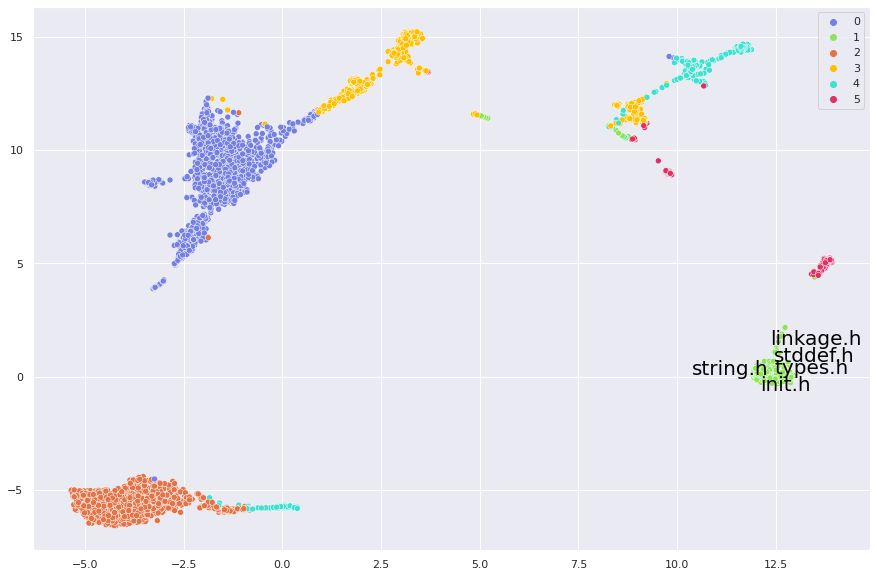

In [77]:
colors = ['#747FE3', '#8EE35D', '#E37346','#FFBF00','#40E0D0','#DE3163']
ax = sns.scatterplot(x = dw_umap_embs[:, 0], y = dw_umap_embs[:, 1], hue = label,palette=colors)
ax.text(dw_umap_embs[relabelling_dict['linkage.h']][0]+0.01, dw_umap_embs[relabelling_dict['linkage.h']][1]+1.60,
        np.array(h_graph.nodes)[relabelling_dict['linkage.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['types.h']][0]+0.01, dw_umap_embs[relabelling_dict['types.h']][1]+0.10,np.array(h_graph.nodes)[relabelling_dict['types.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['stddef.h']][0]+ 0.01, dw_umap_embs[relabelling_dict['stddef.h']][1]+0.70,np.array(h_graph.nodes)[relabelling_dict['stddef.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['init.h']][0]+ 0.01, dw_umap_embs[relabelling_dict['init.h']][1]-1.00,np.array(h_graph.nodes)[relabelling_dict['init.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['string.h']][0]-1.80, dw_umap_embs[relabelling_dict['string.h']][1]+0.10,np.array(h_graph.nodes)[relabelling_dict['string.h']], horizontalalignment='left', fontsize=20, color='black')

Text(-3.56064920425415, 9.862505531311035, 'bnx2_fw.h')

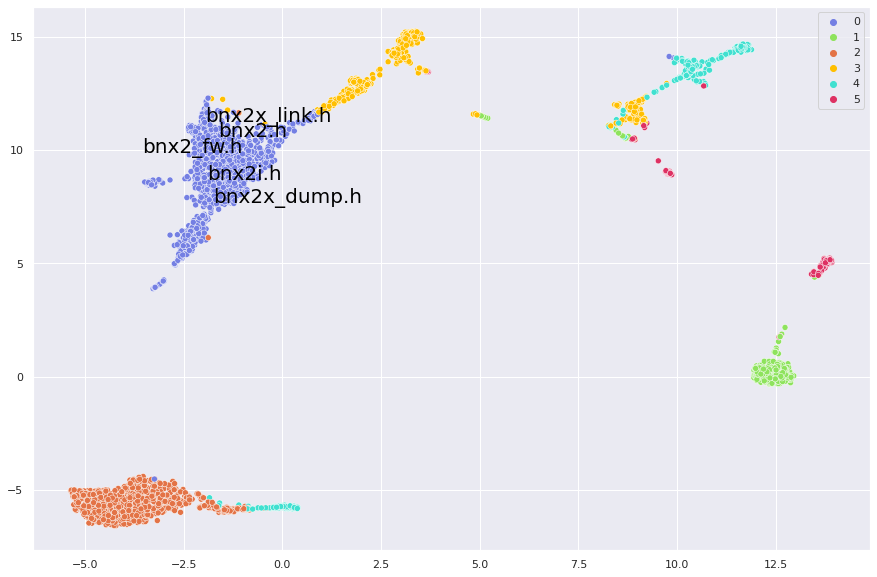

In [35]:
colors = ['#747FE3', '#8EE35D', '#E37346','#FFBF00','#40E0D0','#DE3163']

ax = sns.scatterplot(x = dw_umap_embs[:, 0], y = dw_umap_embs[:, 1], hue = label,palette=colors)
ax.text(dw_umap_embs[relabelling_dict['bnx2i.h']][0]+0.01, dw_umap_embs[relabelling_dict['bnx2i.h']][1]+0.60,np.array(h_graph.nodes)[relabelling_dict['bnx2i.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['bnx2.h']][0]+0.01, dw_umap_embs[relabelling_dict['bnx2.h']][1]+0.20,np.array(h_graph.nodes)[relabelling_dict['bnx2.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['bnx2x_dump.h']][0]+ 0.01, dw_umap_embs[relabelling_dict['bnx2x_dump.h']][1]-0.25,np.array(h_graph.nodes)[relabelling_dict['bnx2x_dump.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['bnx2x_link.h']][0]+ 0.01, dw_umap_embs[relabelling_dict['bnx2x_link.h']][1]+0.10,np.array(h_graph.nodes)[relabelling_dict['bnx2x_link.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['bnx2_fw.h']][0]-1.80, dw_umap_embs[relabelling_dict['bnx2_fw.h']][1]+0.10,np.array(h_graph.nodes)[relabelling_dict['bnx2_fw.h']], horizontalalignment='left', fontsize=20, color='black')

Text(3.2888851261138914, 13.85132713317871, 'crypto.h')

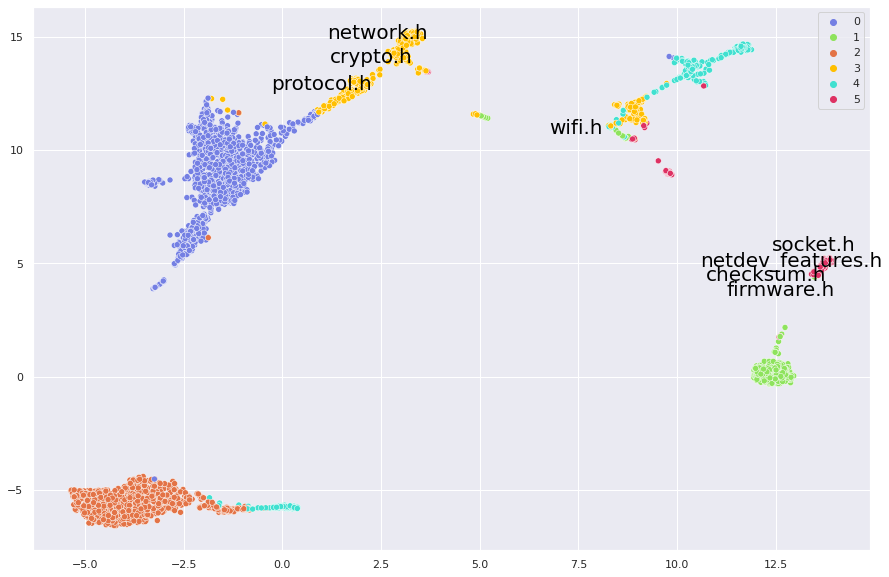

In [78]:
colors = ['#747FE3', '#8EE35D', '#E37346','#FFBF00','#40E0D0','#DE3163']

ax = sns.scatterplot(x = dw_umap_embs[:, 0], y = dw_umap_embs[:, 1], hue = label,palette=colors)
ax.text(dw_umap_embs[relabelling_dict['socket.h']][0]-1.20, dw_umap_embs[relabelling_dict['socket.h']][1]+1.00,np.array(h_graph.nodes)[relabelling_dict['socket.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['netdev_features.h']][0]-3.20, dw_umap_embs[relabelling_dict['netdev_features.h']][1]-0.20,np.array(h_graph.nodes)[relabelling_dict['netdev_features.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['firmware.h']][0]-2.20, dw_umap_embs[relabelling_dict['firmware.h']][1]-0.90,np.array(h_graph.nodes)[relabelling_dict['firmware.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['checksum.h']][0]+0.01, dw_umap_embs[relabelling_dict['checksum.h']][1]-0.80,np.array(h_graph.nodes)[relabelling_dict['checksum.h']], horizontalalignment='right', fontsize=20, color='black')

ax.text(dw_umap_embs[relabelling_dict['protocol.h']][0]-1.20, dw_umap_embs[relabelling_dict['protocol.h']][1]+1.00,np.array(h_graph.nodes)[relabelling_dict['protocol.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['network.h']][0]-2.20, dw_umap_embs[relabelling_dict['network.h']][1]-0.20,np.array(h_graph.nodes)[relabelling_dict['network.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['wifi.h']][0]-2.20, dw_umap_embs[relabelling_dict['wifi.h']][1]-0.90,np.array(h_graph.nodes)[relabelling_dict['wifi.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['crypto.h']][0]+0.01, dw_umap_embs[relabelling_dict['crypto.h']][1]-0.80,np.array(h_graph.nodes)[relabelling_dict['crypto.h']], horizontalalignment='right', fontsize=20, color='black')


Text(-5.013039340972901, -5.843166160583496, 'usbtv.h')

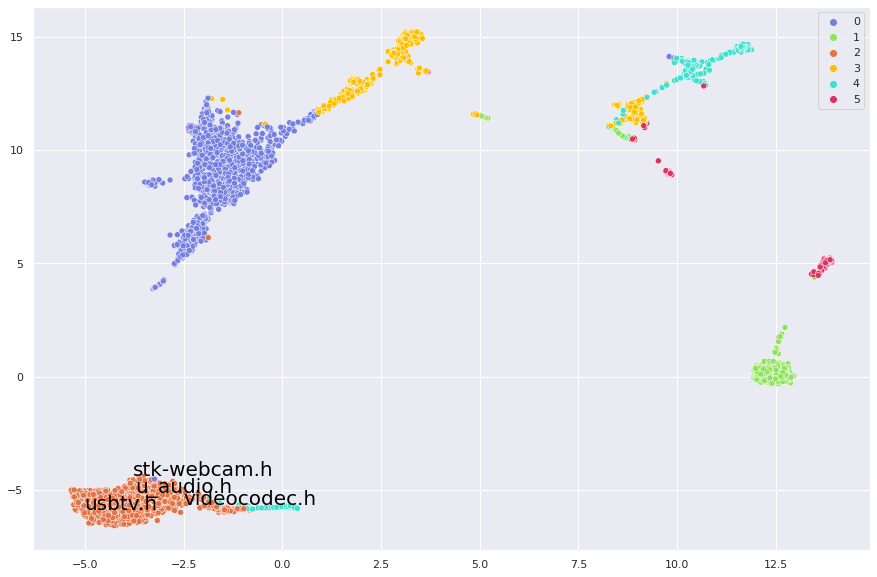

In [66]:
colors = ['#747FE3', '#8EE35D', '#E37346','#FFBF00','#40E0D0','#DE3163']

ax = sns.scatterplot(x = dw_umap_embs[:, 0], y = dw_umap_embs[:, 1], hue = label,palette=colors)
ax.text(dw_umap_embs[relabelling_dict['u_audio.h']][0]+1.20, dw_umap_embs[relabelling_dict['u_audio.h']][1]+1.00,np.array(h_graph.nodes)[relabelling_dict['u_audio.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['videocodec.h']][0]+1.20, dw_umap_embs[relabelling_dict['videocodec.h']][1]-0.20,np.array(h_graph.nodes)[relabelling_dict['videocodec.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['stk-webcam.h']][0]+1.20, dw_umap_embs[relabelling_dict['stk-webcam.h']][1]+0.80,np.array(h_graph.nodes)[relabelling_dict['stk-webcam.h']], horizontalalignment='left', fontsize=20, color='black')
ax.text(dw_umap_embs[relabelling_dict['usbtv.h']][0]+0.01, dw_umap_embs[relabelling_dict['usbtv.h']][1]-0.80,np.array(h_graph.nodes)[relabelling_dict['usbtv.h']], horizontalalignment='left', fontsize=20, color='black')
#svga.h,u_audio.h,videocodec.h,stk-webcam.h,usbtv.h

In [26]:
cluster0_indeces = [i for i in range(len(label)) if label[i] == 0]
cluster1_indeces = [i for i in range(len(label)) if label[i] == 1]
cluster2_indeces = [i for i in range(len(label)) if label[i] == 2]
cluster3_indeces = [i for i in range(len(label)) if label[i] == 3]
cluster4_indeces = [i for i in range(len(label)) if label[i] == 4]
cluster5_indeces = [i for i in range(len(label)) if label[i] == 5]

An example of how we extracted the files belonging to one particular cluster.

In [104]:
np.array(h_graph.nodes)[cluster5_indeces]

array(['jobctl.h', 'socket.h', 'inet_timewait_sock.h',
       'backing-dev-defs.h', 'etherdevice.h', 'blk_types.h', 'packet.h',
       'conntrack.h', 'tcp_states.h', 'in_route.h', 'nsproxy.h',
       'u64_stats_sync.h', 'hashtable.h', 'ipv6.h', 'archrandom.h',
       'once.h', 'if_ether.h', 'timewait_sock.h', 'cryptohash.h', 'smc.h',
       'flow_dissector.h', 'snmp.h', 'inet_connection_sock.h',
       'dst_ops.h', 'ethtool.h', 'cgroup_subsys.h', 'security.h', 'bpf.h',
       'kfifo.h', 'net.h', 'sockios.h', 'x_tables.h', 'bpf-cgroup.h',
       'access_ok.h', 'pps_kernel.h', 'skbuff.h', 'seq_file_net.h',
       'bpf_common.h', 'le_byteshift.h', 'dccp.h', 'ip6_fib.h',
       'packed_struct.h', 'if_addr.h', 'in.h', 'task_stack.h',
       'cgroupstats.h', 'netdev_features.h', 'list_nulls.h', 'bio.h',
       'if_inet6.h', 'ip_fib.h', 'fib_notifier.h', 'csmake-post-defs.h',
       'xdp.h', 'if_packet.h', 'task.h', 'ieee802154_6lowpan.h', 'usb.h',
       'mempool.h', 'unistd.h', 'rculist_nul

In [ ]:
DWclustering = {np.array(h_graph.nodes)[i]: label[i] for i in range(len(label))}

In [ ]:
import json
with open('DWEmbeddingClustering.json', 'w') as fp:
    json.dump(str(DWclustering), fp)